# Libraries

In [1]:
!nvidia-smi

Tue Nov 12 21:56:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |     16MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# install necessary tools
!pip3 install box2d
!apt-get install python-opengl
!python -m pip install pyvirtualdisplay
!pip -q install ./python

#import libraries
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()



    100% |████████████████████████████████| 430kB 2.2MB/s eta 0:00:01
  Running setup.py install for box2d ... done
You are using pip version 9.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


# Environment

In [3]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


# Visulize environment with random action

In [6]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


# Training DQN Agent 

In [7]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=42)

In [8]:
import time

def dqn(n_episodes=3000, max_t=3000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state

        score = 0
        for t in range(max_t): 
            #action = np.random.randint(action_size)        # select an action
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tLatest Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="")
    torch.save(agent.qnetwork_local.state_dict(), 'dqn_checkpoint.pth')
    return scores


# Train the agent using DQN
start_time = time.time() # Monitor Training Time  
scores = dqn(n_episodes=2000, max_t=5000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Episode 2000	Latest Score: 15.00	Average Score: 14.38
Total Training time = 57.8 min


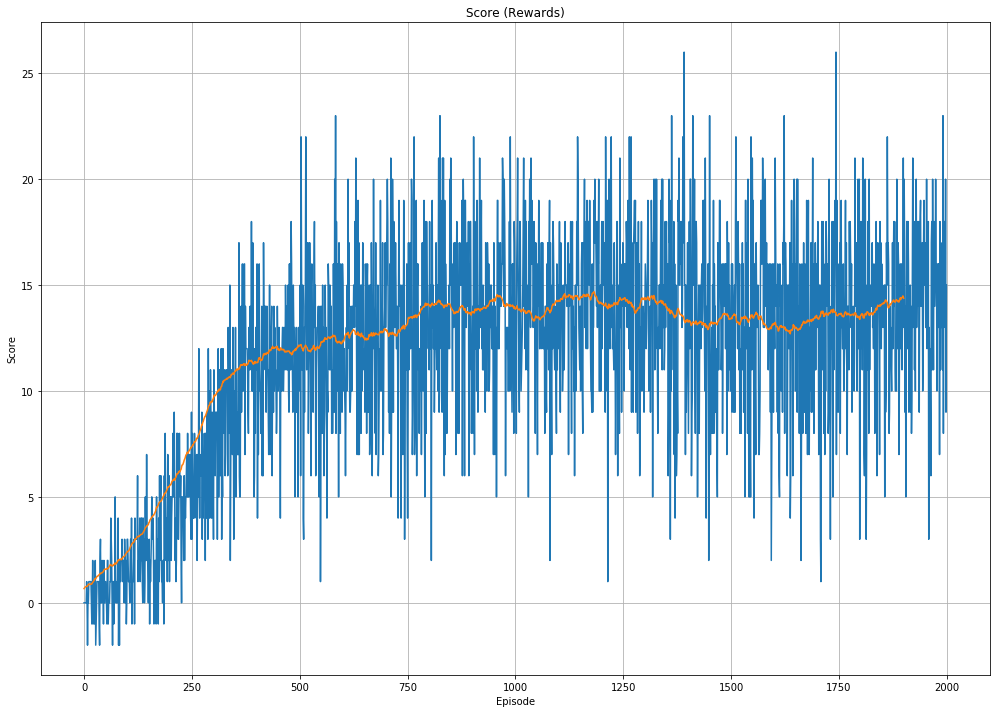

In [18]:
# plot the scores
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ma = moving_average(np.array(scores), 100)

fig = plt.figure(figsize=(17,12))
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(ma)), ma)
plt.title('Score (Rewards)')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.grid(True)  
plt.show()

# Double DQN

In [19]:
from ddqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=42)

In [20]:
# Train the agent using DQN
start_time = time.time() # Monitor Training Time  
scores = dqn(n_episodes=2000, max_t=5000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Episode 2000	Average Score: 11.68
Total Training time = 52.8 min


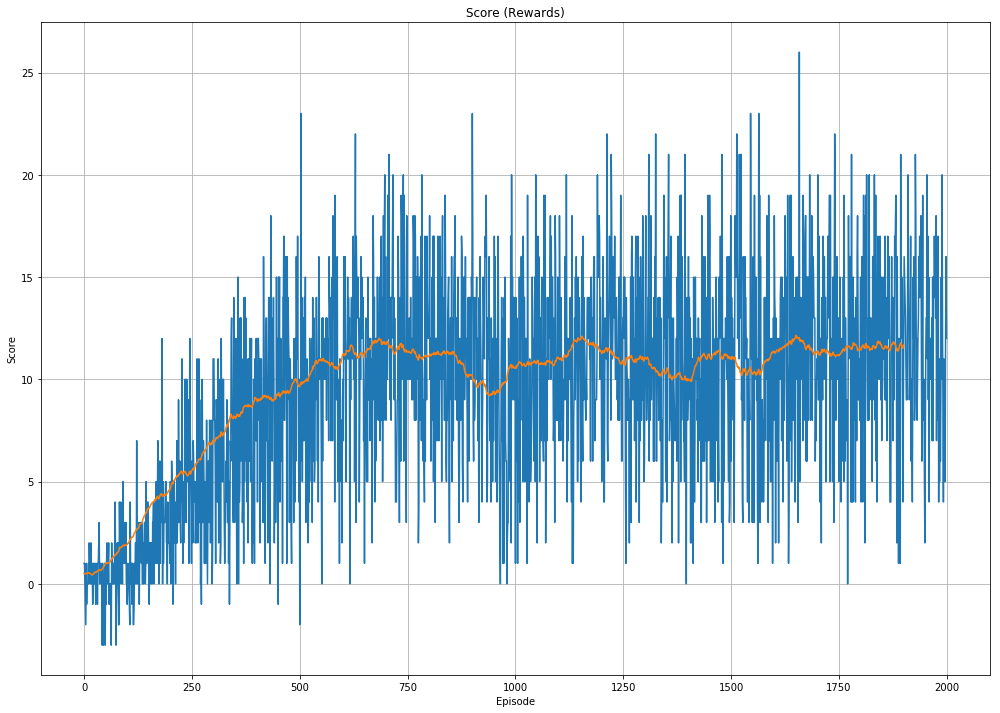

In [22]:
ma = moving_average(np.array(scores), 100)

fig = plt.figure(figsize=(17,12))

plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(ma)), ma)
plt.title('Score (Rewards)')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.grid(True)  
plt.show()